# 1D CNN+LSTM for ECG Classification (2 Leads)

This notebook demonstrates how to preprocess 2 ECG leads, train a 1D CNN+LSTM model, and predict arrhythmia classes based on the model.

## Overview
1. Environment Setup
2. Data Loading and Preprocessing (2 Leads)
3. Model Architecture
4. Training
5. Prediction

Let's get started!

## 1. Environment Setup

First, let's install the required packages and import necessary libraries.

In [4]:
%pip install PyWavelets
%pip install tensorflow
%pip install keras
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import csv
import itertools
import collections
import glob
import re # Import regex for more robust splitting

import pywt # Ensure pywt is imported and installed
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.layers import LSTM, Bidirectional, BatchNormalization, GlobalAveragePooling1D, MaxPool1D, Concatenate
from keras.optimizers import Adam, RMSprop, Adamax, Nadam, SGD
from keras.utils import to_categorical
from keras import regularizers

%matplotlib inline

In [37]:
# Set up plotting parameters
plt.rcParams["figure.figsize"] = (25,6)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

## 2. Data Loading and Preprocessing (2 Leads)

In this section, we'll load ECG data from two leads and preprocess them for our model.

In [38]:
def denoise(signal):
    """
    Denoise an ECG signal using wavelet transform.

    Args:
        signal: The input ECG signal

    Returns:
        Denoised ECG signal
    """
    wavelet = pywt.Wavelet('sym4')
    max_level = pywt.dwt_max_level(len(signal), wavelet.dec_len)
    threshold_ratio = 0.04  # Thresholding factor

    # Decompose signal
    coeffs = pywt.wavedec(signal, wavelet, level=max_level)

    # Apply soft thresholding to detail coefficients only
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold_ratio * np.max(coeffs[i]), mode='soft')

    # Reconstruct the denoised signal
    denoised_signal = pywt.waverec(coeffs, wavelet)

    return denoised_signal

In [39]:
# Path to the folder (relative or absolute)
path = './mitbih_database/' # Ensure path ends with a slash for os.path.join

# Parameters
window_size = 180
maximum_counting = 10000

# Define the arrhythmia classes
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0] * n_classes

# Initialize data containers
X_lead1 = []
X_lead2 = []
y = []

# Get all file paths in the directory
record_files = glob.glob(os.path.join(path, '*.csv'))
annotation_files = glob.glob(os.path.join(path, '*.txt'))

# Sort to ensure consistent order for pairing
record_files.sort()
annotation_files.sort()

# Corrected: Create a dictionary to easily map record base names to their annotation files
# Remove 'annotations' from the key for matching
annotations_map = {}
for f in annotation_files:
    base_name = os.path.splitext(os.path.basename(f))[0]
    # This is the key change: strip 'annotations' from the base name
    key = base_name.replace('annotations', '')
    annotations_map[key] = f

Number of records found: 48
Records: ['100.csv', '101.csv', '102.csv', '103.csv', '104.csv', '105.csv', '106.csv', '107.csv', '108.csv', '109.csv', '111.csv', '112.csv', '113.csv', '114.csv', '115.csv', '116.csv', '117.csv', '118.csv', '119.csv', '121.csv', '122.csv', '123.csv', '124.csv', '200.csv', '201.csv', '202.csv', '203.csv', '205.csv', '207.csv', '208.csv', '209.csv', '210.csv', '212.csv', '213.csv', '214.csv', '215.csv', '217.csv', '219.csv', '220.csv', '221.csv', '222.csv', '223.csv', '228.csv', '230.csv', '231.csv', '232.csv', '233.csv', '234.csv']
Annotations: ['100annotations.txt', '101annotations.txt', '102annotations.txt', '103annotations.txt', '104annotations.txt', '105annotations.txt', '106annotations.txt', '107annotations.txt', '108annotations.txt', '109annotations.txt', '111annotations.txt', '112annotations.txt', '113annotations.txt', '114annotations.txt', '115annotations.txt', '116annotations.txt', '117annotations.txt', '118annotations.txt', '119annotations.txt', '1

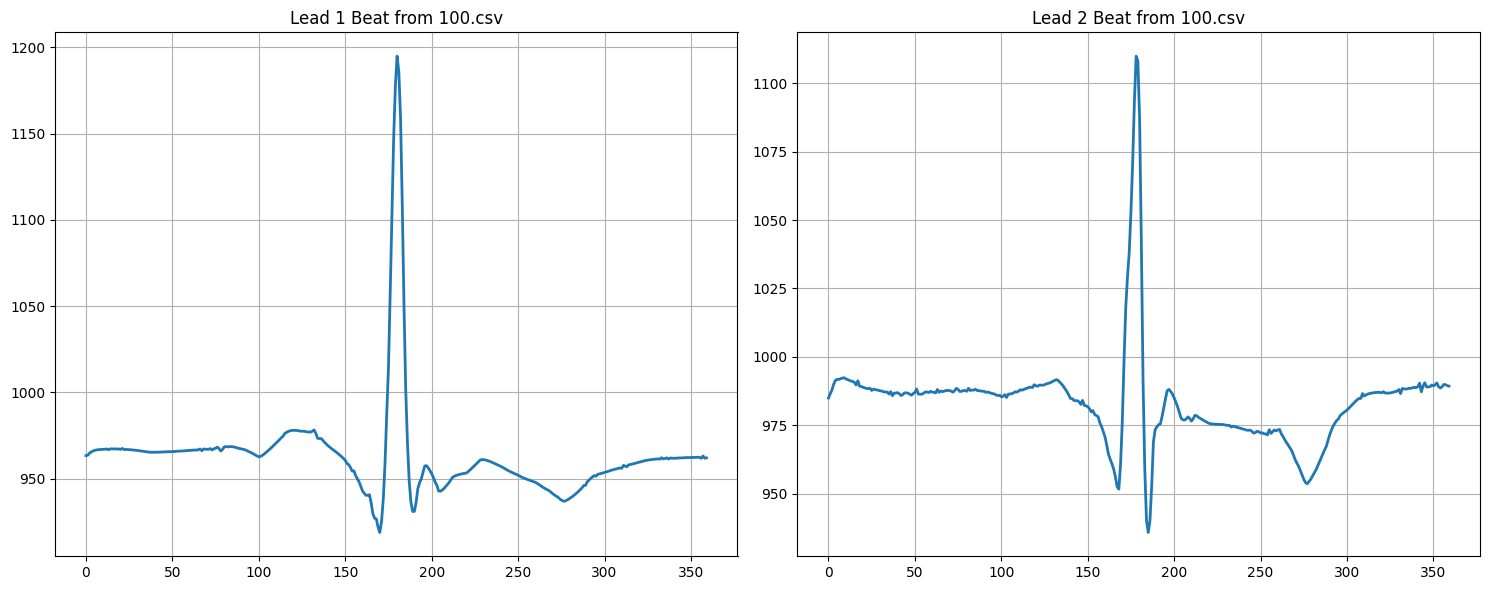

Processed 2274 annotations, 2271 valid beats extracted for 100
Processing record: ./mitbih_database/101.csv
Processed 1874 annotations, 1862 valid beats extracted for 101
Processing record: ./mitbih_database/102.csv
Processed 2192 annotations, 103 valid beats extracted for 102
Processing record: ./mitbih_database/103.csv
Processed 2091 annotations, 2083 valid beats extracted for 103
Processing record: ./mitbih_database/104.csv
Processed 2311 annotations, 165 valid beats extracted for 104
Processing record: ./mitbih_database/105.csv
Processed 2691 annotations, 2567 valid beats extracted for 105
Processing record: ./mitbih_database/106.csv
Processed 2098 annotations, 2027 valid beats extracted for 106
Processing record: ./mitbih_database/107.csv
Processed 2140 annotations, 59 valid beats extracted for 107
Processing record: ./mitbih_database/108.csv
Processed 1824 annotations, 1759 valid beats extracted for 108
Processing record: ./mitbih_database/109.csv
Processed 2535 annotations, 2528

In [40]:
# Load and process data from two leads
example_beat_printed = False

print(f"Number of records found: {len(record_files)}")
print(f"Records: {[os.path.basename(f) for f in record_files]}")
print(f"Annotations: {[os.path.basename(f) for f in annotation_files]}")

for r_path in record_files:
    record_basename = os.path.splitext(os.path.basename(r_path))[0]
    annotation_path = annotations_map.get(record_basename)

    if annotation_path is None:
        print(f"No matching annotation file found for record: {r_path}. Skipping.")
        continue

    print(f"Processing record: {r_path}")

    try:
        record_data = pd.read_csv(r_path, header=0)
    except Exception as e:
        print(f"Error loading CSV {r_path}: {e}")
        continue

    try:
        signals_lead1 = record_data.iloc[:, 1].values
        signals_lead2 = record_data.iloc[:, 2].values if record_data.shape[1] > 2 else np.zeros_like(signals_lead1)
    except Exception as e:
        print(f"Error extracting signals from {r_path}: {e}")
        continue

    # Denoise signals
    signals_lead1 = denoise(signals_lead1)
    signals_lead2 = denoise(signals_lead2)

    try:
        annotation_count = 0
        valid_annotation_count = 0

        with open(annotation_path, 'r') as fileID:
            data = fileID.readlines()
            for d in range(1, len(data)):
                # Ensure 're' is defined before this line
                splitted = re.split(r'\s+', data[d].strip())
                if len(splitted) < 3:
                    continue

                try:
                    pos = int(splitted[1])
                    arrhythmia_type = splitted[2]
                except (ValueError, IndexError):
                    continue

                annotation_count += 1
                if arrhythmia_type in classes:
                    arrhythmia_index = classes.index(arrhythmia_type)

                    if window_size <= pos < (len(signals_lead1) - window_size):
                        valid_annotation_count += 1
                        beat_lead1 = signals_lead1[pos - window_size : pos + window_size]
                        beat_lead2 = signals_lead2[pos - window_size : pos + window_size]

                        # Plot an example of beats from both leads (only once)
                        if not example_beat_printed:
                            plt.figure(figsize=(15, 6))
                            plt.subplot(1, 2, 1)
                            plt.title(f"Lead 1 Beat from {os.path.basename(r_path)}")
                            plt.plot(beat_lead1)

                            plt.subplot(1, 2, 2)
                            plt.title(f"Lead 2 Beat from {os.path.basename(r_path)}")
                            plt.plot(beat_lead2)
                            plt.tight_layout()
                            plt.show()
                            example_beat_printed = True # Set to True after printing

                        X_lead1.append(beat_lead1)
                        X_lead2.append(beat_lead2)
                        y.append(arrhythmia_index)

        print(f"Processed {annotation_count} annotations, {valid_annotation_count} valid beats extracted for {record_basename}")
    except Exception as e:
        print(f"Error processing annotations for {annotation_path}: {e}")
        continue

# Convert to numpy arrays
X_lead1 = np.array(X_lead1)
X_lead2 = np.array(X_lead2)
y = np.array(y)

print(f"\nInitial Lead 1 shape: {X_lead1.shape}")
print(f"Initial Lead 2 shape: {X_lead2.shape}")
print(f"Initial Labels shape: {y.shape}")

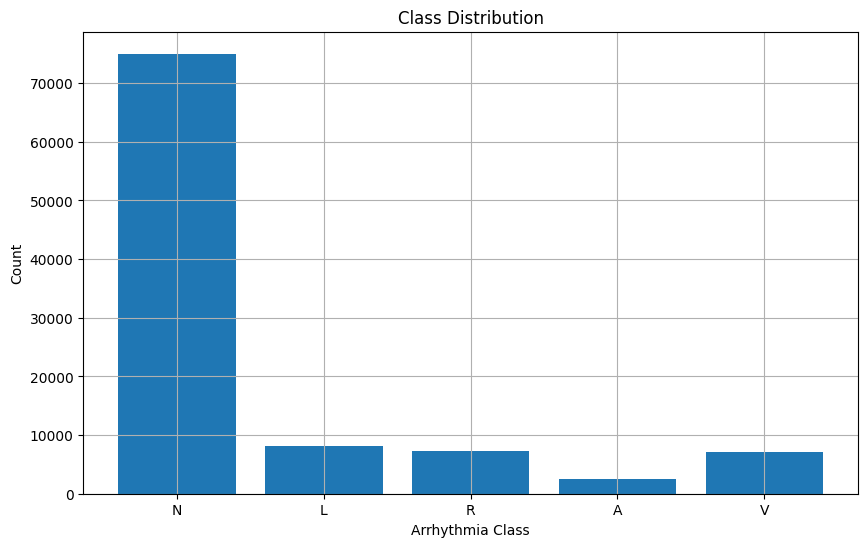

In [41]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
# Ensure the counts reflect the actual data collected
plt.bar(classes, [collections.Counter(y)[i] for i in range(len(classes))])
plt.title('Class Distribution')
plt.xlabel('Arrhythmia Class')
plt.ylabel('Count')
plt.show()

In [42]:
# Normalize the data before balancing (important for consistency with model input)
scaler = MinMaxScaler()
X_lead1_scaled = np.zeros_like(X_lead1, dtype=np.float32)
X_lead2_scaled = np.zeros_like(X_lead2, dtype=np.float32)

for i in range(len(X_lead1)):
    X_lead1_scaled[i] = scaler.fit_transform(X_lead1[i].reshape(-1, 1)).flatten()
    X_lead2_scaled[i] = scaler.fit_transform(X_lead2[i].reshape(-1, 1)).flatten()

# --- Combine X_lead1_scaled, X_lead2_scaled, and y for balancing ---
# Concatenate the features from both leads horizontally
X_combined_features = np.concatenate((X_lead1_scaled, X_lead2_scaled), axis=1)

# Convert combined features and y into a DataFrame for balancing
# Create a list of column names for the features
feature_cols = [f'feature_{i}' for i in range(X_combined_features.shape[1])]
df_combined = pd.DataFrame(X_combined_features, columns=feature_cols)
df_combined['target'] = y # Add the target labels as the last column

# --- Class Distribution Before Balancing ---
print("\nClass Distribution Before Balancing:")
class_counts_before = df_combined['target'].value_counts().sort_index()
print(class_counts_before)


Class Distribution Before Balancing:
target
0    75011
1     8071
2     7255
3     2546
4     7129
Name: count, dtype: int64


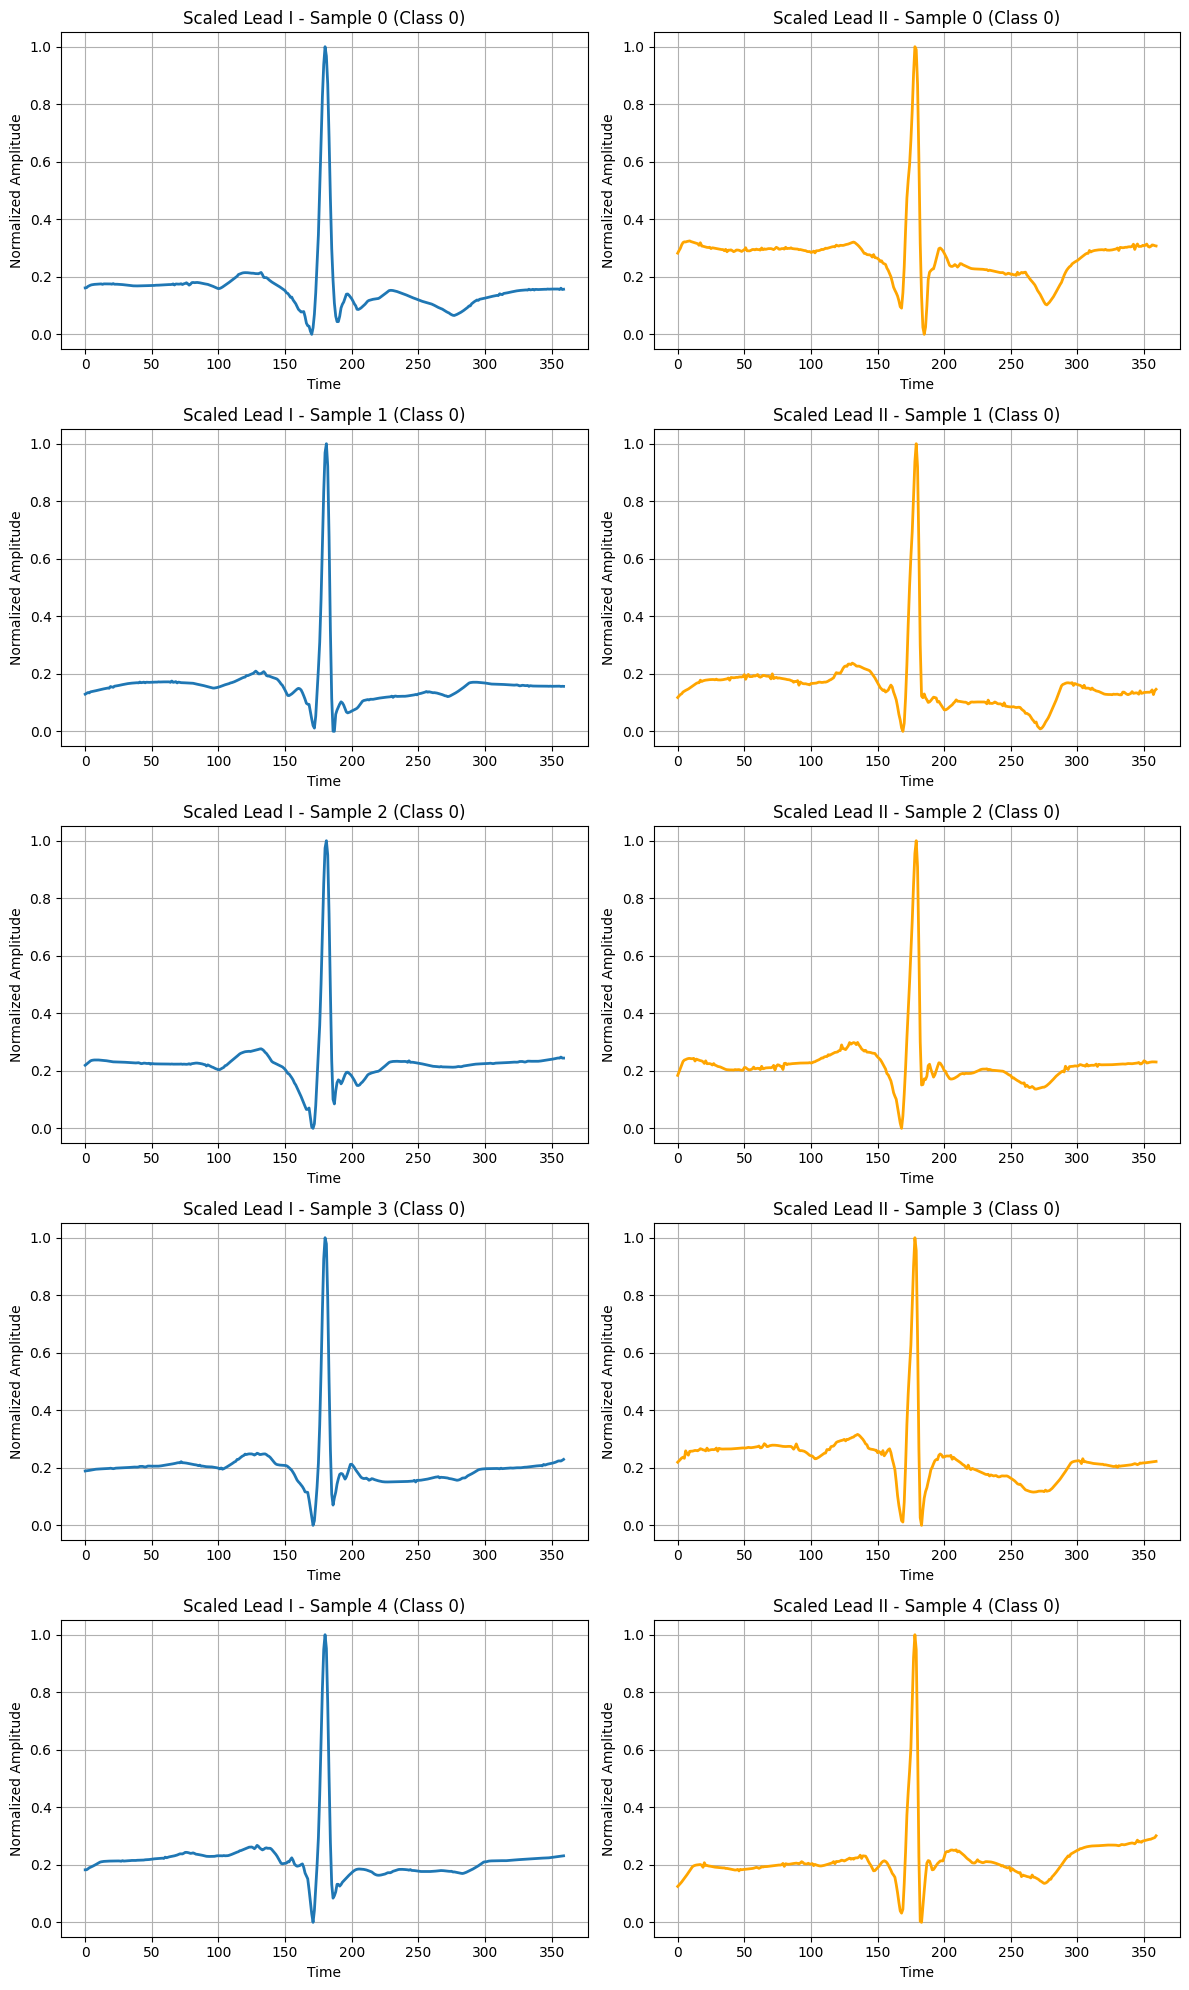

In [43]:
import matplotlib.pyplot as plt

def plot_scaled_beats(X_lead1_scaled, X_lead2_scaled, y, num_samples=5):
    """
    Plot scaled ECG beats from both leads.
    """
    plt.figure(figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.plot(X_lead1_scaled[i], label=f'Lead I - Class {y[i]}')
        plt.title(f'Scaled Lead I - Sample {i} (Class {y[i]})')
        plt.xlabel('Time')
        plt.ylabel('Normalized Amplitude')
        plt.grid(True)

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.plot(X_lead2_scaled[i], label=f'Lead II - Class {y[i]}', color='orange')
        plt.title(f'Scaled Lead II - Sample {i} (Class {y[i]})')
        plt.xlabel('Time')
        plt.ylabel('Normalized Amplitude')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot the first 5 beats
plot_scaled_beats(X_lead1_scaled, X_lead2_scaled, y, num_samples=5)

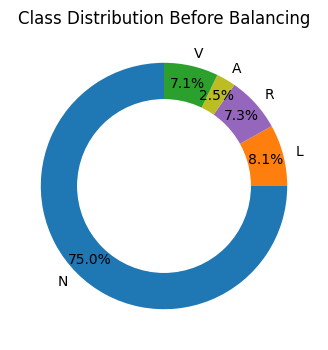

In [16]:
# Plot class distribution before balancing (donut chart)
plt.figure(figsize=(4, 4))
center_circle = plt.Circle((0, 0), 0.7, color='white')
labels_plot = ['N', 'L', 'R', 'A', 'V'] # Ensure labels match your classes
colors_plot = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green']

if not class_counts_before.empty:
    plt.pie(class_counts_before, labels=labels_plot, colors=colors_plot, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    plt.gca().add_artist(center_circle)
    plt.title('Class Distribution Before Balancing')
    plt.show()
else:
    print("No data available for plotting class distribution before balancing.")

Downsampled class 0 (N): 75011 -> 5000
Downsampled class 1 (L): 8071 -> 5000
Downsampled class 2 (R): 7255 -> 5000
Upsampled class 3 (A): 2546 -> 5000
Downsampled class 4 (V): 7129 -> 5000

Shape of X_balanced (combined leads): (25000, 720)
Class Distribution After Balancing:
0    5000
1    5000
2    5000
3    5000
4    5000
Name: count, dtype: int64


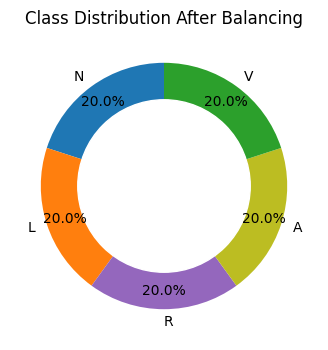

In [ ]:
# --- Data Balancing (Upsampling/Downsampling) ---
target_samples = 5000 # Define target number of samples for each class

balanced_dfs = [] # Use a list to collect dataframes

# Iterate through each unique class present in the data
unique_classes = np.sort(df_combined['target'].unique())

for class_label in unique_classes:
    df_class = df_combined[df_combined['target'] == class_label]
    current_count = len(df_class)

    if current_count < target_samples:
        # Upsample any class with fewer than target_samples
        balanced_df_class = resample(df_class,
                                     replace=True,     # Resample with replacement
                                     n_samples=target_samples,
                                     random_state=42 + class_label) # Different seed for each class
        print(f"Upsampled class {class_label} ({labels_plot[class_label]}): {current_count} -> {len(balanced_df_class)}")
    elif current_count > target_samples:
        # Downsample any class with more than target_samples
        balanced_df_class = resample(df_class,
                                     replace=False,    # Do not resample with replacement
                                     n_samples=target_samples,
                                     random_state=42 + class_label)
        print(f"Downsampled class {class_label} ({labels_plot[class_label]}): {current_count} -> {len(balanced_df_class)}")
    else: # current_count == target_samples
        # If the count is already exactly the target, keep it as is
        balanced_df_class = df_class
        print(f"Class {class_label} ({labels_plot[class_label]}): {current_count} (already equal to target). No change.")
    
    balanced_dfs.append(balanced_df_class)

# Combine balanced data into one DataFrame
df_balanced = pd.concat(balanced_dfs)

# Optional: Shuffle the dataset (recommended)
df_balanced = df_balanced.sample(frac=1, random_state=99).reset_index(drop=True)

# Separate features and labels after balancing
# The feature columns are all columns except the last one ('target')
X_balanced = df_balanced.drop('target', axis=1).values
y_balanced = df_balanced['target'].values

print("\nShape of X_balanced (combined leads):", X_balanced.shape)
print(f"Class Distribution After Balancing:\n{pd.Series(y_balanced).value_counts().sort_index()}")

# Plot class distribution after balancing (donut chart)
plt.figure(figsize=(4, 4))
center_circle = plt.Circle((0, 0), 0.7, color='white')

class_counts_after = pd.Series(y_balanced).value_counts().sort_index()

if not class_counts_after.empty:
    plt.pie(class_counts_after, labels=labels_plot, colors=colors_plot, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    plt.gca().add_artist(center_circle)
    plt.title("Class Distribution After Balancing")
    plt.show()
else:
    print("No data available for plotting class distribution after balancing.")

In [ ]:
# --- Split the balanced data for training, validation, and test ---
# First, split X_balanced back into lead1 and lead2 for model input
# Each original sample has window_size * 2 features from Lead1 and window_size * 2 from Lead2
half_features = X_lead1_scaled.shape[1] # This is window_size * 2, e.g., 360

X_balanced_lead1 = X_balanced[:, :half_features]
X_balanced_lead2 = X_balanced[:, half_features:]

# Convert labels to one-hot encoding
y_balanced_one_hot = to_categorical(y_balanced, num_classes=n_classes)

# Split the data into training, validation, and test sets
# Stratify by y_balanced_one_hot to maintain class distribution
X_lead1_train_val, X_lead1_test, \
X_lead2_train_val, X_lead2_test, \
y_train_val, y_test = train_test_split(
    X_balanced_lead1, X_balanced_lead2, y_balanced_one_hot,
    test_size=0.2, random_state=42, stratify=y_balanced_one_hot
)

# Then split training+validation into training and validation
X_lead1_train, X_lead1_val, \
X_lead2_train, X_lead2_val, \
y_train, y_val = train_test_split(
    X_lead1_train_val, X_lead2_train_val, y_train_val,
    test_size=0.25, random_state=42, stratify=y_train_val # 0.25 of 0.8 is 0.2 of total
)

print(f"\nTraining set: {X_lead1_train.shape[0]} samples")
print(f"Validation set: {X_lead1_val.shape[0]} samples")
print(f"Test set: {X_lead1_test.shape[0]} samples")


Training set: 15000 samples
Validation set: 5000 samples
Test set: 5000 samples


## 3. Model Architecture

Now we'll create a model that processes two leads and combines them for classification.

In [16]:
# --- Model Definition (FIXED: input_shape for Conv1D) ---
def create_model(input_shape, n_classes):

    # Input layers for each lead
    input_lead1 = Input(shape=input_shape, name='lead1_input')
    input_lead2 = Input(shape=input_shape, name='lead2_input')

    # Function to create a branch for each lead
    def create_branch(input_layer, name_prefix):
        # First convolutional block
        x = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', name=f'{name_prefix}_conv1')(input_layer)
        x = BatchNormalization(name=f'{name_prefix}_bn1')(x)
        x = MaxPooling1D(pool_size=2, name=f'{name_prefix}_pool1')(x)

        # Second convolutional block
        x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name=f'{name_prefix}_conv2')(x)
        x = BatchNormalization(name=f'{name_prefix}_bn2')(x)
        x = MaxPooling1D(pool_size=2, name=f'{name_prefix}_pool2')(x)

        # LSTM layer
        x = Bidirectional(LSTM(64, return_sequences=True), name=f'{name_prefix}_bilstm')(x)
        x = GlobalAveragePooling1D(name=f'{name_prefix}_gap')(x)

        return x

    # Create branches for each lead
    branch1 = create_branch(input_lead1, 'lead1')
    branch2 = create_branch(input_lead2, 'lead2')

    # Concatenate the outputs from both branches
    combined = Concatenate(name='concatenate')([branch1, branch2])

    # Dense layers for classification
    x = Dense(128, activation='relu', name='dense1')(combined)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(64, activation='relu', name='dense2')(x)
    x = Dropout(0.3, name='dropout2')(x)

    # Output layer
    output = Dense(n_classes, activation='softmax', name='output')(x)

    # Create and compile the model
    model = Model(inputs=[input_lead1, input_lead2], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [17]:
# Create the model with the correct input shape (based on original lead signal length)
# FIXED: Added '1' for the features dimension.
input_shape = (X_lead1_train.shape[1], 1) # This should be (window_size * 2, 1)
model = create_model(input_shape, n_classes)

# Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lead1_input (InputLayer)    [(None, 360, 1)]             0         []                            
                                                                                                  
 lead2_input (InputLayer)    [(None, 360, 1)]             0         []                            
                                                                                                  
 lead1_conv1 (Conv1D)        (None, 360, 64)              384       ['lead1_input[0][0]']         
                                                                                                  
 lead2_conv1 (Conv1D)        (None, 360, 64)              384       ['lead2_input[0][0]']         
                                                                                              

## 4. Training

Now we'll train the model using our preprocessed data.

In [18]:
# --- Model Training ---
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train the model using the balanced training and validation sets
history = model.fit(
    [X_lead1_train, X_lead2_train],
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=([X_lead1_val, X_lead2_val], y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
469/469 [==============================] - 42s 84ms/step - loss: 0.7804 - accuracy: 0.7050 - val_loss: 2.7416 - val_accuracy: 0.2982 - lr: 0.0010
Epoch 2/50
469/469 [==============================] - 38s 81ms/step - loss: 0.2903 - accuracy: 0.9075 - val_loss: 0.2186 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 3/50
469/469 [==============================] - 40s 85ms/step - loss: 0.2142 - accuracy: 0.9336 - val_loss: 0.5376 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 4/50
469/469 [==============================] - 38s 82ms/step - loss: 0.1734 - accuracy: 0.9439 - val_loss: 0.3091 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 5/50
469/469 [==============================] - 37s 79ms/step - loss: 0.1581 - accuracy: 0.9497 - val_loss: 0.1407 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 6/50
469/469 [==============================] - 37s 80ms/step - loss: 0.1410 - accuracy: 0.9562 - val_loss: 0.1379 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 7/50
469/469 [==============================] - 38s 

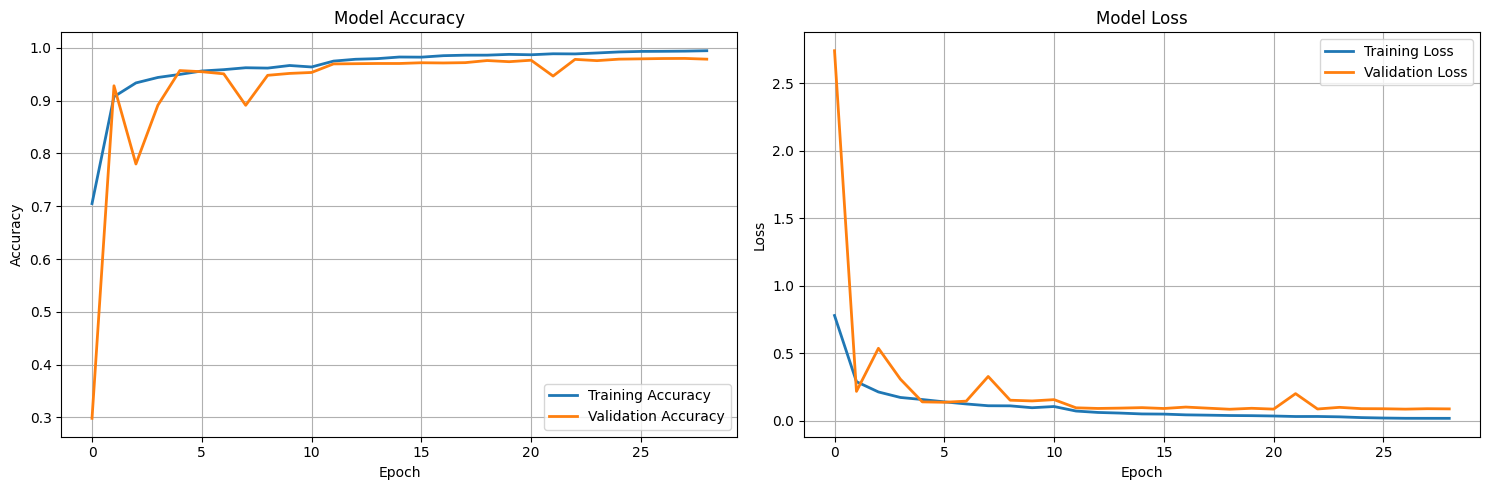

In [19]:
# --- Plot Training History ---
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Prediction

Now we'll evaluate the model on the test set and make predictions.

In [20]:
# --- Evaluate the model on the test set ---
test_loss, test_accuracy = model.evaluate([X_lead1_test, X_lead2_test], y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



157/157 [==============================] - 3s 16ms/step - loss: 0.0812 - accuracy: 0.9766
Test Loss: 0.0812
Test Accuracy: 0.9766


In [21]:
# --- Make predictions on the test set ---
y_pred_prob = model.predict([X_lead1_test, X_lead2_test])
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))


157/157 [==============================] - 3s 16ms/step

Classification Report:
              precision    recall  f1-score   support

           N       0.94      0.96      0.95      1000
           L       1.00      1.00      1.00      1000
           R       0.99      1.00      0.99      1000
           A       0.97      0.94      0.96      1000
           V       0.99      0.98      0.99      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



<Figure size 1000x800 with 0 Axes>

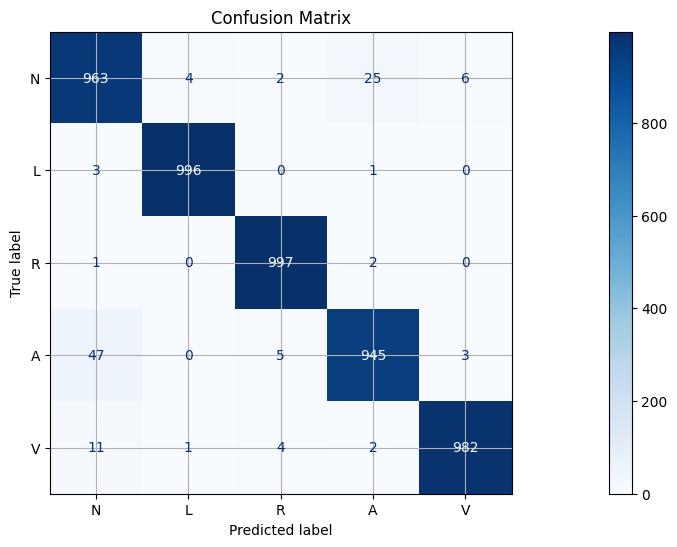

In [22]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## 6. Prediction on New Data

Let's create a function to make predictions on new ECG data.

In [34]:
# --- Prediction Function for a single beat ---
from tensorflow.keras.models import load_model
model = load_model('ecg_2leads_model.h5')
def predict_arrhythmia(model, lead1_signal, lead2_signal, window_size=180):
    """
    Predict arrhythmia class for a given ECG signal from two leads.

    Args:
        model: Trained model
        lead1_signal: ECG signal from lead 1 (should be a single beat of shape (window_size*2,))
        lead2_signal: ECG signal from lead 2 (should be a single beat of shape (window_size*2,))
        window_size: Window size for beat extraction (half the total beat length)

    Returns:
        Predicted class label (string) and probability
    """
    # Ensure signals are numpy arrays
    lead1_signal = np.array(lead1_signal)
    lead2_signal = np.array(lead2_signal)

    # Denoise signals - apply only if the input is a raw signal.
    # If the input is already a preprocessed beat from X_balanced_lead1/2, denoising is not needed.
    # For a general prediction function, it's safer to include it.
    lead1_signal = denoise(lead1_signal)
    lead2_signal = denoise(lead2_signal)

    # The model expects beats of length `window_size * 2`.
    expected_length = 2 * window_size

    if len(lead1_signal) != expected_length:
        raise ValueError(f"Input signal length mismatch. Expected {expected_length} samples for a beat, but got {len(lead1_signal)}. "
                         "This function expects an already extracted beat, not a full signal with R-peak detection.")

    beat_lead1 = lead1_signal
    beat_lead2 = lead2_signal

    # Normalize beats using the same scaler or a new one for this specific prediction
    # For prediction, it's best to use the same scaler used during training, but here
    # we're creating a new one per prediction. For simplicity here, a new one is created.
    scaler_pred = MinMaxScaler()
    beat_lead1_scaled = scaler_pred.fit_transform(beat_lead1.reshape(-1, 1)).flatten()
    beat_lead2_scaled = scaler_pred.fit_transform(beat_lead2.reshape(-1, 1)).flatten()

    # Reshape for model input (add batch dimension AND features dimension)
    beat_lead1_scaled = np.expand_dims(beat_lead1_scaled, axis=0)
    beat_lead1_scaled = np.expand_dims(beat_lead1_scaled, axis=-1) # Add features dim
    
    beat_lead2_scaled = np.expand_dims(beat_lead2_scaled, axis=0)
    beat_lead2_scaled = np.expand_dims(beat_lead2_scaled, axis=-1) # Add features dim

    # Make prediction
    prediction = model.predict([beat_lead1_scaled, beat_lead2_scaled])[0]
    predicted_class = np.argmax(prediction)
    probability = prediction[predicted_class]

    return classes[predicted_class], probability



In [35]:
# --- Example: Predict on a sample from the test set ---
# This uses the already balanced and split test data
sample_idx = 10 # Choose a sample from the test set

# Get the sample from the test set
sample_lead1_test = X_lead1_test[sample_idx]
sample_lead2_test = X_lead2_test[sample_idx]
true_class = classes[np.argmax(y_test[sample_idx])]

# Make prediction using the predict_arrhythmia function
# The window_size for predict_arrhythmia should match the length of a single lead's beat/window
# X_lead1_test.shape[1] is (window_size * 2), so window_size for the function is half of that.
predicted_class, probability = predict_arrhythmia(
    model,
    sample_lead1_test,
    sample_lead2_test,
    window_size=X_lead1_test.shape[1] // 2
)

# Display results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title(f"Lead 1 - True: {true_class}, Predicted: {predicted_class} ({probability:.2f})")
plt.plot(sample_lead1_test)

plt.subplot(1, 2, 2)
plt.title(f"Lead 2 - True: {true_class}, Predicted: {predicted_class} ({probability:.2f})")
plt.plot(sample_lead2_test)

plt.tight_layout()
plt.show()



KeyError: 10

## 7. Save the Model


In [29]:
# --- Save the model ---
model.save('ecg_2leads_model.h5')
print("Model saved as 'ecg_2leads_model.h5'")

Model saved as 'ecg_2leads_model.h5'


/Users/asalaal-amri/anaconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
